# **Object Detection with Faster RCNN**

Code is for the following video: https://www.youtube.com/watch?v=Uc90rr5jbA4&t=71s

Do give this notebook a thumbs-up if you liked it. Thanks!

## **1. Import lab**

In [1]:
import numpy as np
import pandas as pd
import os

import torch

# Check version torchvision
try:
  import torchvision
  print('torchvision version: ', torchvision.__version__)
  assert int(torchvision.__version__.split('.')[1] >= 16)
except:
  !pip install -U torchvision
  import torchvision
  print('torchvision version: ', torchvision.__version__)

from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms
from torch import nn, optim
from torch.nn import functional
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as album
import matplotlib.pyplot as plt
%matplotlib inline

# remove warnings (optional)
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

torchvision version:  0.16.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.8 MB

torchvision version:  0.16.0+cu118


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [2]:
# Our dataset is in cocoformat, we well need pypcoco tools
try:
  from pycocotools.coco import coco
except:
  !pip install pycocotools
  from pycocotools.coco import COCO

## **2. Define our transforms**

* Now, we will define our transforms
* We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [3]:
from albumentations.pytorch import ToTensorV2

def get_transforms(train = False):
  if train:
    transform = album.Compose([
        album.Resize(600, 600), # our output size can be 600px
        album.HorizontalFlip(p = 0.3),
        album.VerticalFlip(p = 0.3),
        album.RandomBrightnessContrast(p = 0.1),
        album.ColorJitter(p = 0.1),
        ToTensorV2()
    ], bbox_params = album.BboxParams(format = 'coco'))

  else:
    transform = album.Compose([
        album.Resize(600, 600),
        ToTensorV2()
    ], bbox_params = album.BboxParams(format = 'coco'))

  return transform

## **3. Datasets**

This is our dataset class. it loads all the necessary files and it processes the data, so that it can be fed into the model.

In [14]:
class AquariumDetection(datasets.VisionDataset):
  def __init__(self, root, split = 'train', transform = None, target_transform = None, transforms = None):
    # the 3 transform parameters are required for datasets.VisionDataset
    super().__init__(root, transforms, transform, target_transform)
    self.split = split
    self.coco = COCO(os.path.join(root, split, '_annotations.coco.json')) # annotations stored here
    self.ids = list(sorted(self.coco.imgs.keys()))
    self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

  def _load_image(self, id:int):
    path = self.coco.loadImgs(id)[0]['file_name']
    image = cv2.imread(os.path.join(self.root, self.split, path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

  def _load_target(self, id):
    return self.coco.loadAnns(self.coco.getAnnIds(id))

  def __getitem__(self, index):
    id = self.ids[index]
    image = self._load_image(id)
    target = self._load_target(id)
    target = copy.deepcopy(self._load_target(id))

    boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
    if self.transforms is not None:
      transformed = self.transforms(image = image, bboxes = boxes)

    image = transformed['image']
    boxes = transformed['bboxes']

    new_boxes = [] # convert form xywh to xyxy
    for box in boxes:
      xmin = box[0]
      xmax = xmin + box[2]
      ymin = box[1]
      ymax = ymin + box[3]
      new_boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.tensor(new_boxes, dtype = torch.float32)

    targ = {} # here is our transformed target
    targ['boxes'] = boxes
    targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype = torch.int64)
    targ['image_id'] = torch.tensor([t['image_id'] for t in target])
    targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
    targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype = torch.int64)
    return image.div(225), targ # scale images

  def __len__(self):
    return len(self.ids)

In [5]:
# {"username":"trnxunkhanh","key":"62a4723df323602ae71c070c0ce05a35"}
os.environ['KAGGLE_USERNAME'] = 'trnxunkhanh'
os.environ['KAGGLE_KEY'] = '62a4723df323602ae71c070c0ce05a35'

In [6]:
try:
  !kaggle datasets download sharansmenon/aquarium-dataset
  !unzip -qq aquarium-dataset.zip
except:
  !pip install kaggle
  !kaggle datasets download sharansmenon/aquarium-dataset
  !unzip -qq aquarium-dataset.zip


100% 68.0M/68.0M [00:05<00:00, 19.8MB/s]
100% 68.0M/68.0M [00:05<00:00, 13.7MB/s]


In [7]:
dataset_path = 'Aquarium Combined/'

# Load dataset
coco = COCO(os.path.join(dataset_path, 'train', '_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

This code just gets a list of classes

In [8]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [15]:
train_dataset = AquariumDetection(root = dataset_path,
                                  transforms = get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [18]:
len(train_dataset)

447

This is a sample image and its bounding boxes, this code does not get the model's output

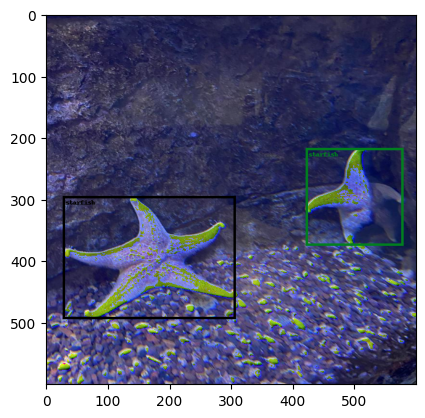

In [17]:
# View a sample
sample = train_dataset[5]
img_int = torch.tensor(sample[0] * 255, dtype = torch.uint8)
plt.imshow(draw_bounding_boxes(img_int,
                               sample[1]['boxes'],
                               [classes[i] for i in sample[1]['labels']],
                               width = 4).permute(1, 2, 0))

## **4. Model**

Our model FasterRCNN with a backbond of `MobileNetV3-Large`. we need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [20]:
# Load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # change the haed
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 57.1MB/s]


This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [21]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [22]:
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True,
                          num_workers = 4, collate_fn = collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [23]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # make sure it run without error

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
model = model.to(device)

## **5. Optimizer**
Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [27]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.01, momentum = 0.9,
                            nesterov = True, weight_decay = 1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22],
#                                                     gamma=0.1) # lr scheduler

In [28]:
import sys

## **6. Training**

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`.

In [44]:
def train_one_epoch(model, optimizer, loader, device, epoch):
  model.to(device)
  model.train()

  # lr_scheduler = None
  # if epoch == 0:
  #     warmup_factor = 1.0 / 1000 # do lr warmup
  #     warmup_iters = min(1000, len(loader) - 1)

  #     lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

  all_losses = []
  all_losses_dict = []

  for images, targets in tqdm(loader):
    images = list(image.to(device) for image in images)
    targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets) # the model computes the loss automatically if we pass ikn targets
    losses = sum(loss for loss in loss_dict.values())
    loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
    loss_value = losses.item()

    all_losses.append(loss_value)
    all_losses_dict.append(loss_dict_append)

    if not math.isfinite(loss_value):
      print(f'Loss is {loss_value}, stopping training') # train if loss becomes infinity
      print(loss_dict)
      sys.exit(1)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

      # if lr_scheduler is not None:
      #   lr_scheduler.step()

  all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
  print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
    epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
    all_losses_dict['loss_classifier'].mean(),
    all_losses_dict['loss_box_reg'].mean(),
    all_losses_dict['loss_rpn_box_reg'].mean(),
    all_losses_dict['loss_objectness'].mean()))

10 Epochs should be enough to train this model for a high accuracy

In [45]:
num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, epoch)
  # lr_scheduler.step()

100%|██████████| 112/112 [00:22<00:00,  4.93it/s]


Epoch 0, lr: 0.010000, loss: 0.988217, loss_classifier: 0.472760, loss_box: 0.394411, loss_rpn_box: 0.033071, loss_object: 0.087974


100%|██████████| 112/112 [00:21<00:00,  5.26it/s]


Epoch 1, lr: 0.010000, loss: 0.831261, loss_classifier: 0.386160, loss_box: 0.357881, loss_rpn_box: 0.028674, loss_object: 0.058545


100%|██████████| 112/112 [00:20<00:00,  5.36it/s]


Epoch 2, lr: 0.010000, loss: 0.742135, loss_classifier: 0.315901, loss_box: 0.348043, loss_rpn_box: 0.026977, loss_object: 0.051213


100%|██████████| 112/112 [00:20<00:00,  5.54it/s]


Epoch 3, lr: 0.010000, loss: 0.705907, loss_classifier: 0.285536, loss_box: 0.352473, loss_rpn_box: 0.025316, loss_object: 0.042582


100%|██████████| 112/112 [00:21<00:00,  5.27it/s]


Epoch 4, lr: 0.010000, loss: 0.668984, loss_classifier: 0.259082, loss_box: 0.350371, loss_rpn_box: 0.023485, loss_object: 0.036046


100%|██████████| 112/112 [00:20<00:00,  5.52it/s]


Epoch 5, lr: 0.010000, loss: 0.676945, loss_classifier: 0.263704, loss_box: 0.357581, loss_rpn_box: 0.022177, loss_object: 0.033483


100%|██████████| 112/112 [00:19<00:00,  5.64it/s]


Epoch 6, lr: 0.010000, loss: 0.658091, loss_classifier: 0.244925, loss_box: 0.360182, loss_rpn_box: 0.022858, loss_object: 0.030127


100%|██████████| 112/112 [00:20<00:00,  5.40it/s]


Epoch 7, lr: 0.010000, loss: 0.661265, loss_classifier: 0.251056, loss_box: 0.362389, loss_rpn_box: 0.020722, loss_object: 0.027099


100%|██████████| 112/112 [00:19<00:00,  5.72it/s]


Epoch 8, lr: 0.010000, loss: 0.616047, loss_classifier: 0.226530, loss_box: 0.342036, loss_rpn_box: 0.020707, loss_object: 0.026775


100%|██████████| 112/112 [00:19<00:00,  5.73it/s]

Epoch 9, lr: 0.010000, loss: 0.623764, loss_classifier: 0.224249, loss_box: 0.354821, loss_rpn_box: 0.020544, loss_object: 0.024150


## **Trying on sample Images**

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [46]:
# we will watch first epoch to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [47]:
test_dataset = AquariumDetection(root = dataset_path, split = 'test',
                                 transforms = get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [50]:
image, _ = test_dataset[8]
img_int = torch.tensor(image * 255, dtype = torch.uint8)
with torch.no_grad():
  prediction = model([image.to(device)])
  pred = prediction[0]

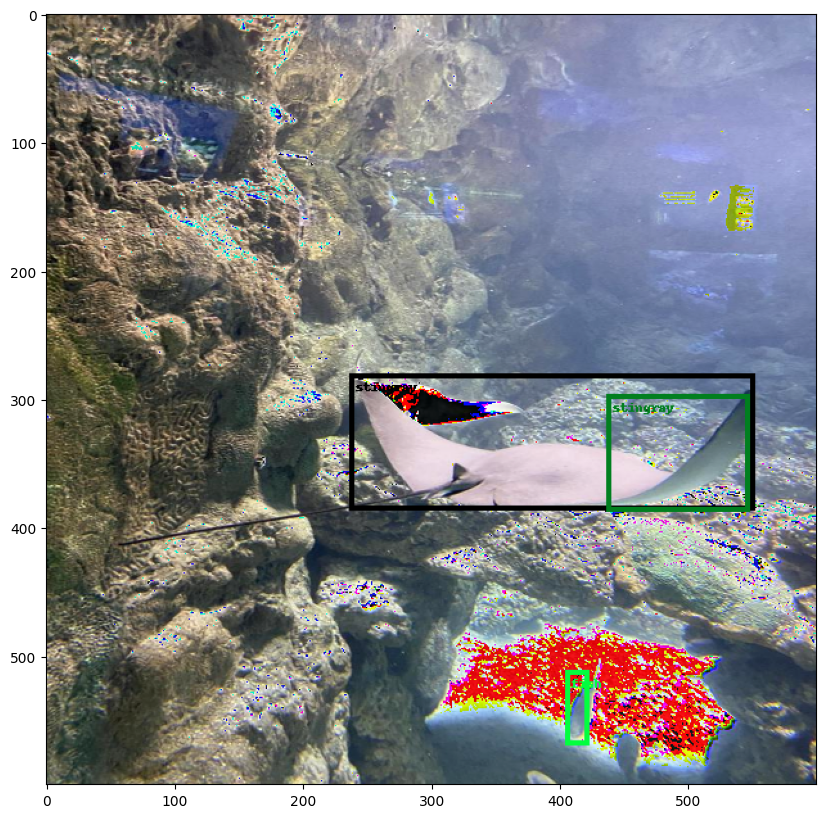

In [51]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))